### Using network science to predict behaviour of a worm based on its brain network 

** WORK IN PROGRESS **

Regarding the brain as a network is also a perfectly valid application of graph theory. This idea of modelling the brain using network science is far from new, but having the computational tools to do anything interesting about it is. This notebook deals with one of such application on the much studied nematode C. *elegans*. The adult worm has only 959 cells. It has 302 neurons, 282 of which are play a role in controlling the body movement (the remaining control the pharynx. A number of studies have mapped this connection diagram (*connectome*), and a complete map exists, freely available online.

A study in Nature (Yan et al., 2017) reveals how graph theory was applied to reveal a hitherto unknown neuron which plays a crucial role in the locomotion of C. *elegans*, as well as identifying previously established results. Here we will reproduce parts of the study.


Attempting to reproduce parts of https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5710776/

more:

http://barabasi.com/f/919.pdf
https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001066

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1995545/

data for the experiment (video): https://figshare.com/s/72716a92be1ab0f1e1d4

As usual, we start by importing necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Next we locate and import the connectome data set.

In [17]:
data_dir = Path.cwd() / 'data'
print(data_dir.exists())

data_fn = data_dir / 'NeuronConnect_wormatlas.xls'
print(data_fn.exists())

True
True


In [18]:
data = pd.read_excel(data_fn)
data.head()

,Neuron 1,Neuron 2,Type,Nbr
0,ADAR,ADAL,EJ,1
1,ADFL,ADAL,EJ,1
2,ASHL,ADAL,EJ,1
3,AVDR,ADAL,EJ,2
4,PVQL,ADAL,EJ,1


The data has four fields. **Neuron 1** is the pre-synaptic neuron and **Neuron 2** is the post-synaptic. **Type** is the type of synapse, and **Nbr** is the number of synapses from Neuron1 to Neuron2. We are not interested in the Type column.

#### Ex 1: a) remove the *Type* column. 

In [19]:
data.drop(['Type'], axis=1, inplace=True)
#comment: the "inplace=True" ensures that the data is dropped in place, without needing to write something 
#along the lines of data = data.drop(...) 

In [20]:
data.head()

,Neuron 1,Neuron 2,Nbr
0,ADAR,ADAL,1
1,ADFL,ADAL,1
2,ASHL,ADAL,1
3,AVDR,ADAL,2
4,PVQL,ADAL,1


#### The current data only holds information about the neurons. We also need to know the connections to the muscles

In [23]:
muscles_fn = data_dir / 'Neuron_to_muscles_wormatlas.xls'
print(muscles_fn.exists())

True


#### Ex. Read the excel file into a pandas dataframe called 'muscles'

In [24]:
muscles = pd.read_excel(muscles_fn)

In [25]:
muscles.head()

,Neuron,Landmark,Landmark Position,Weight
0,IL1R,Sensory,0.0,1.0
1,IL2L,Sensory,0.0,1.0
2,IL2R,Sensory,0.0,1.0
3,IL1L,Sensory,0.0,1.0
4,IL2VL,Sensory,0.0,1.0


We don't care about the column "Landmark Position".

In [26]:
muscles.drop(columns=['Landmark Position'], inplace=True)
muscles.head()

,Neuron,Landmark,Weight
0,IL1R,Sensory,1.0
1,IL2L,Sensory,1.0
2,IL2R,Sensory,1.0
3,IL1L,Sensory,1.0
4,IL2VL,Sensory,1.0


As seen above, the data contains information about other connections too, like input from sensory cells, and muscle cells of no interest. We wish to only keep body wall muscles (those involved in controlling locomotion).

In [27]:
## only keep body wall muscles - the ones with name prefixes MDR/L or MVR/L.
mscl = muscles.loc[:,"Landmark"].str.match(pat = "^M[DV][LR]")

#comment: this matching algorithm is known as a regular expression. This one lets you match for a string
#beginning with and M, followed by a D or V, followed by a L or R. In other words it will match anything 
#starting with "MDL", "MDR", "MVL" or "MVR"

In [28]:
# number of body wall muscles
muscles[mscl].loc[:,"Landmark"].unique().shape

(95,)

#### Ex: Remove the rows in `muscles` which are not body wall muscles.

In [29]:
muscles = muscles[mscl]

We chain the two dataframes together.

In [33]:
muscles.rename(columns = dict(zip(muscles.columns, data.columns)), inplace=True)
data = data.append(muscles, ignore_index=True)
data.head()

,Neuron 1,Neuron 2,Nbr
0,ADAR,ADAL,1.0
1,ADFL,ADAL,1.0
2,ASHL,ADAL,1.0
3,AVDR,ADAL,2.0
4,PVQL,ADAL,1.0


Like they did in the study, we don't care about the number of synapses per connection, but signify each connection either as a **1** or a **0**. Secondly, we also don't care about the Type column. This is the last necessary step to complete our preprocessing. 

#### Ex 2. Set all values in *Nbr* to 1. 

In [36]:
data.loc[:,'Nbr'] = np.ones(shape=(data.shape[0]),) # set all repeated synapses to 1

#comment: np.ones creates a vector of 1s, with a specified length (we set this to the size of the data frame).
#comment 2: when modifying a dataframe, we recommend using the `.loc` method.

Networkx can read this format as into a Graph object using `from_pandas_edgelist`:

In [41]:
# create graph object
G = nx.from_pandas_edgelist(data, 'Neuron 1', 'Neuron 2', ['Nbr'])

In [42]:
# remove dummy node NMJ; neuromuscular junction
G.remove_node("NMJ")
print(G.number_of_nodes())

377


Currently, the network is disconnected (some subnetworks are unreachable from eachother), perhaps because of incomplete data. We can proceed by only keeping the largest one.

In [43]:
nx.connected.number_connected_components(G)

3

In [44]:
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))
G = G.subgraph(largest_cc).copy() #our new graph

374


In [46]:
G.has_node('PDB')

True

The nodes sorted by degree indicate the more influential nodes (high degree) versus less influential.

In [77]:
sorted(G.degree(), key = lambda x: x[1], reverse=True)

[('AVAR', 93),
 ('AVAL', 92),
 ('AVBL', 75),
 ('AVBR', 74),
 ('AVER', 56),
 ('AVDR', 55),
 ('AVEL', 55),
 ('PVCL', 54),
 ('PVCR', 53),
 ('DVA', 50),
 ('AVDL', 44),
 ('RIBL', 40),
 ('AIBR', 39),
 ('RIAR', 36),
 ('RIBR', 36),
 ('RIMR', 35),
 ('RMDVR', 35),
 ('AIBL', 34),
 ('AVKL', 34),
 ('RIAL', 33),
 ('RIGL', 33),
 ('HSNR', 33),
 ('RIH', 32),
 ('RMDL', 32),
 ('RIML', 31),
 ('AVJL', 31),
 ('ADEL', 30),
 ('PVR', 30),
 ('RMGL', 30),
 ('AVJR', 29),
 ('AVL', 29),
 ('SMDDR', 29),
 ('DD01', 29),
 ('RMDVL', 29),
 ('PVT', 28),
 ('RIS', 28),
 ('SMDDL', 28),
 ('PVNR', 28),
 ('VA12', 28),
 ('RMDR', 27),
 ('DVC', 27),
 ('RMDDL', 27),
 ('DB03', 27),
 ('RMGR', 26),
 ('RMDDR', 26),
 ('DD02', 26),
 ('ADAL', 25),
 ('RICL', 25),
 ('AVKR', 25),
 ('RIGR', 25),
 ('PVPR', 25),
 ('PVNL', 25),
 ('RMEV', 25),
 ('RICR', 24),
 ('PVQR', 24),
 ('ADER', 24),
 ('SMDVL', 24),
 ('CEPDR', 24),
 ('AIZL', 24),
 ('AIZR', 24),
 ('AVHL', 24),
 ('HSNL', 24),
 ('VB01', 24),
 ('AVFL', 24),
 ('DA02', 24),
 ('PVPL', 23),
 ('SMBDR'

#### Ex 2. Make a list of the node degrees in G. Convert it to a numpy array.

In [53]:
node_degrees = np.array([e for v,e in list(G.degree())])

#### Ex. Plot the network, set the node size to be proportional to the node degrees.

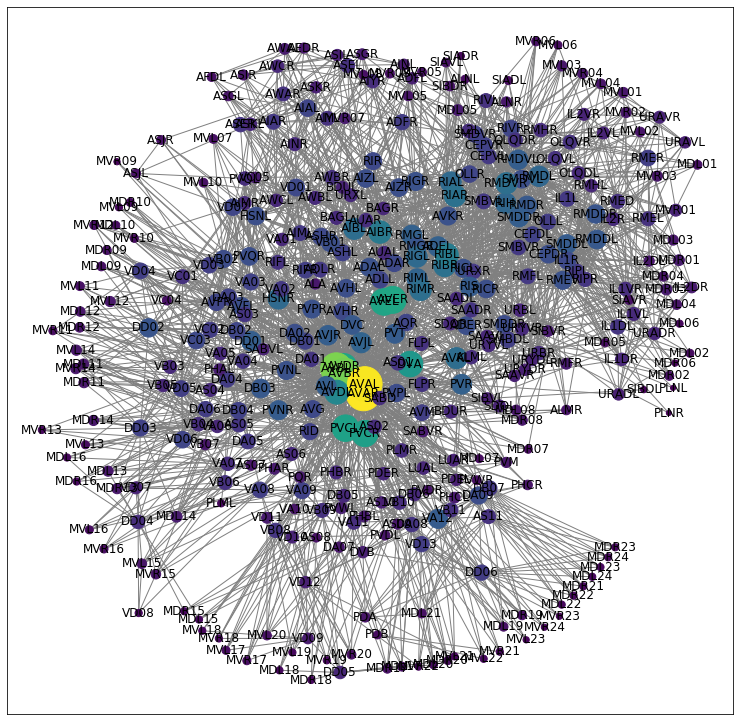

In [75]:
pos = nx.kamada_kawai_layout(G)

figsize = (13,13)
plt.figure(figsize=figsize)

nx.draw_networkx_nodes(G, pos, node_color=node_degrees,
                       node_size=node_degrees*13)

nx.draw_networkx_edges(G, pos, edge_color='gray')

nx.draw_networkx_labels(G, pos)

plt.show()

So already, simply by computing the node degree, we are directed to the most influential nodes. How do we know these are more important? Previous experiments have shown that the four top nodes, AVAR, AVAL, AVBR, AVBL, were already experimentally known to single-handedly cause motor dysfunction through laser ablation. This is not surprising, considering how many connections that are lost by removing one of them.

The neurons AVDR, PVCR, PVCL, AVDL which are ranked at 6th, 8th, 9th and 11th in the node degree hierarchy have also been expermentally validated as being crucial. 


In [80]:
sorted(G.degree(), key = lambda x: x[1], reverse=True)[:11]

[('AVAR', 93),
 ('AVAL', 92),
 ('AVBL', 75),
 ('AVBR', 74),
 ('AVER', 56),
 ('AVDR', 55),
 ('AVEL', 55),
 ('PVCL', 54),
 ('PVCR', 53),
 ('DVA', 50),
 ('AVDL', 44)]

Thus we know that simple, straight forward network analysis can take us surprisingly far. However, we shouldn't stop here. First of all, there are many cases of high-degree nodes which *don't* exert any significant power over motion patterns. Secondly, there exists a range of low-degree which *do* play an important role. 

Like the researchers in the original paper, we will take the analysis a step farther. 

They identified another neuron with a key role in motor control, which was later confirmed experimentally. We will replicate the result here. 

### Control theory
The research is rooted in control theory: based on the structural connectivity, how can one signal control the output? Can different outputs be controlled independently? By outputs here, we mean muscle cells, the actual effectors of behaviour. Each muscle cell is innervated by motor neuron - the interface from neuron and mucle. Just from the definitions it is obvious that obliterating a motor neuron has a crucial impact on motor function. 

A basic result in control theory is that using k control units, at most k output units can be independently controllable. So for instance, if we wish to control 3 muscle cells through the bottleneck of 2 motor neurons, we can only control 2 of the muscles independently. (use figure for this). 

This becomes important as each muscle needs to be innervated by motor neurons.

To copmute this we need to introduce some values. 

First, M is the number of control targets (muscles). N is the number of neurons (N). The connection diagram of the neurons and muscles is an N+M x N+M matrix, **A**. **B** is a N+MxS matrix signifying which nodes receive external control signals (e.g. sensory signals). **C** is a matrix, where each row signifies which units we attempt to control (i.e. the muscles).  

Kalman's criterion is a theoretical prerequisite for a system to be controllable: 
$$ rank [CB, CAB, CA^2B, ..., CA^{N+M+1}B] = M$$

A problem with computing this is that there exist an incomprehensible amount of configurations for the edge weights, and we would need to test all of them. Instead the researchers used *structural controlability*, which is only dependent on the connectome *structure*, without regarding its exact synapse weights or the input signals.

#### Simple example

we have N=2 neurons and M=2 muscles. We name the cells (neurons and muscles combined) from 1 to 4 (which is assigned as 1, which is 2... is not important). The connectivity diagram is represented as a matrix A, below. B is the matrix of which cells receive external input (i.e. sensory input). C is the matrix over nodes we wish to control (basically just 1 for muscle cells and 0 for neurons).

In [153]:
# you are not expected to understand this code, but it simply checks whether the Kalman criterion is held.
def is_kalman(kal, M, random_state=1):
    """Whether kalman condition is satisfied. 
    Non-zero weights are randomly set to avoid a Lebesque measure of zero."""
    kal_rnd = kal*np.random.rand(*kal.shape)
    rk = np.linalg.matrix_rank(kal*kal_rnd)
    print(f"Rank = {rk} \t M = {M}")
    return(rk == M)

def kalman(A,B,C,M,N):
    """produces the matrix [CB, CAB, CA^2B....CA^(M+N-1)B]"""
    ll = []
    for k in range(M+N):
        ll.append(_kalman(A,B,C,k))
    return np.concatenate(ll, axis=1)

def _kalman(A,B,C,k):
    """Helper function, computes matrix product C A^k B"""
    if k==0: return C.dot(B)
    return _kalman(A, B, C.dot(A), k-1)

rnk = np.linalg.matrix_rank

The matrix entries are set to 1 just to signify a connection, but the actual weight is not necessarily 1 (in fact that is highly unlikely. 

In [157]:
A = np.array([[0,0,0,0],
              [1,0,0,0],
              [1,0,0,0],
              [0,0,1,0]])

B = np.array([[1,0,0,0]]).T

C = np.array([[0,1,0,0],
             [0,0,0,1]])

M = C.shape[0]
N = A.shape[0] - M
print(M, N)

2 2


In [158]:
[print(m, end='\n\n') for m in [A,B,C]]

[[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]

[[1]
 [0]
 [0]
 [0]]

[[0 1 0 0]
 [0 0 0 1]]



[None, None, None]

In [159]:
kal = kalman(A,B,C,M,N)
print(kal)
is_kalman(kal, M)

[[0 1 0 0]
 [0 0 1 0]]
Rank = 2 	 M = 2


True

In this case we change the desired control units from 2 and 4 to 2 and 3.

In [160]:
# another case
C = np.array([[0,1,0,0],
              [0,0,1,0]])

kal = kalman(A,B,C,M,N)
print(kal)
is_kalman(kal,M)

[[0 1 0 0]
 [0 1 0 0]]
Rank = 1 	 M = 2


False

In [162]:
A = np.array([[0,0,0],
              [1,0,1],
              [1,1,0]])
B = np.array([[1,0,0]]).T
C = np.array([[0,1,0],
             [0,0,1]])

M = C.shape[0]
N = A.shape[0] - M

kal = kalman(A,B,C,M,N)
print(kal)
is_kalman(kal, M)

[[0 1 1]
 [0 1 1]]
Rank = 2 	 M = 2


True

In [163]:
kalman(A,B,C,M,N)

array([[0, 1, 1],
       [0, 1, 1]])

In [164]:
# example from Liu et al (2011) https://www.nature.com/articles/nature10011.pdf
A = np.array([[0,0,0,0],
              [1,0,0,0],
              [1,0,0,1],
              [1,0,0,0]])

B = np.array([[1,0,0,0],
             [0,1,0,0]]).T

C = np.eye(*A.shape)

M = C.shape[0]; N=A.shape[0]-M
print(M, N)

4 0


In [166]:
kal = kalman(A,B,C,M,N)
print(kal)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [167]:
is_kalman(kal, M)

Rank = 4 	 M = 4


True

In [89]:
nx.algorithms.bipartite.maximum_matching(G)

NetworkXError: Graph is not bipartite.